In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
import torch
import argparse
import random
from torch import nn
from torch.nn import functional as F
import os
from pathlib import Path
import numpy as np
import torch.optim as optim
from torchvision.transforms.transforms import RandomApply
from core.transforms import GaussianBlur, TwoCropsTransform
from core.custom_dataset import DatasetFolderSorted, ImageFolderSorted
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from agents.net import MLP, Encoder

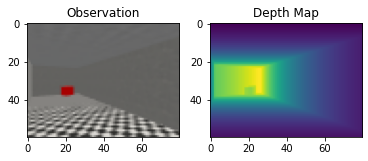

In [3]:
from core.utils import load_demo
d = load_demo('demos/MiniWorld-Hallway-v0/agent/demo_1635805980.pickle')
d.play()

In [4]:
# !python -m agents.behavior_clone --data_path dataset/MiniWorld-Hallway-v0

In [5]:
# train_dataset = datasets.ImageFolder('dataset/MiniWorld-Hallway-v0')
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

train_dataset = ImageFolderSorted(
    'dataset/MiniWorld-FourRooms-v0/agent/D300',
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalizer
    ])
)

In [6]:
from IPython.display import display
i = 0
label_seen = set()
ylist = []
for d, y in train_dataset:
    if y not in label_seen:
        print(i, d.size(), y)
        label_seen.add(y)
    i+= 1
    ylist.append(y)
    # if i > 3:
    #     break
ylist[43]

0 torch.Size([3, 224, 224]) 0
15 torch.Size([3, 224, 224]) 2
26 torch.Size([3, 224, 224]) 1
6911 torch.Size([3, 224, 224]) 4
10277 torch.Size([3, 224, 224]) 3


2

In [7]:
train_dataset.classes

['0', '1', '2', '3', '7']

In [8]:
class TCN_Train_Dataset(Dataset):
    def __init__(self, image_path, positive_frame_margin=10, negative_frame_margin=50, transform=None):
        super(TCN_Train_Dataset, self).__init__()
        self.data = ImageFolderSorted(image_path, transform)
        self.positive_frame_margin = positive_frame_margin
        self.negative_frame_margin = negative_frame_margin

    def __getitem__(self, idx):
        anchor_idx = idx
        p_idx = self.sample_positive_frame_index(idx)
        n_idx = self.sample_negative_frame_indices(idx)
        return {'anchor': self.data[anchor_idx],
                "positive": self.data[p_idx],
                "negative": self.data[n_idx]}

    def sample_positive_frame_index(self, anchor_index):
        lower_bound = max(0, anchor_index - self.positive_frame_margin)
        range1 = np.arange(lower_bound, anchor_index)
        upper_bound = min(len(self.data), anchor_index + self.positive_frame_margin)
        range2 = np.arange(anchor_index + 1, upper_bound)
        return np.random.choice(np.concatenate([range1, range2]))

    def sample_negative_frame_indices(self, anchor_index):
        video_length = len(self.data)
        lower_bound = 0
        upper_bound = max(0, anchor_index - self.negative_frame_margin)
        range1 = np.arange(lower_bound, upper_bound)
        lower_bound = min(anchor_index + self.negative_frame_margin, video_length)
        upper_bound = video_length
        range2 = np.arange(lower_bound, upper_bound)
        range_options = np.concatenate([range1, range2])
        return np.random.choice(range_options)

    def __len__(self):
        return len(self.data)

In [9]:
train_set = TCN_Train_Dataset('dataset/MiniWorld-Hallway-v0/agent/D250', transform=transforms.Compose([
                                                                            transforms.Resize((50, 50)),
                                                                            transforms.ToTensor(),
                                                                            normalizer
                                                                        ]))

In [10]:
for name, (x, y) in train_set[0].items():
    print(name, x.size(), y)

anchor torch.Size([3, 50, 50]) 2
positive torch.Size([3, 50, 50]) 2
negative torch.Size([3, 50, 50]) 2


In [11]:
data_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)

In [12]:
model = nn.Sequential(Encoder()).cuda()
model

Sequential(
  (0): Encoder(
    (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 10, kernel_size=(7, 7), stride=(1, 1))
    (conv3): Conv2d(10, 16, kernel_size=(7, 7), stride=(1, 1))
    (fc1): Linear(in_features=1600, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [13]:
class Encoder_2(nn.Module):
    def __init__(self, dim=128) -> None:
        super().__init__()
        # In: 3x50x50
        self.conv1 = nn.Conv2d(3, 6, 7) # Out:   6x44x44
        self.pool = nn.MaxPool2d(2, 2)  # Out:   6x22x22
        self.conv2 = nn.Conv2d(6, 10, 7) # Out: 10x16x16
        self.conv3 = nn.Conv2d(10, 16, 7) # Out: 16x10x10
        self.fc1 = nn.Linear(16 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, dim)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [14]:
class Normalize_Net(nn.Module):
    def forward(self, x):
        buffer = torch.pow(x, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        normalization_constant = torch.sqrt(normp)
        output = torch.div(x, normalization_constant.view(-1, 1).expand_as(x))
        return output
model = nn.Sequential(Encoder_2(), Normalize_Net()).cuda()

In [15]:
def distance(x1, x2):
    # diff = torch.abs(x1 - x2)
    # return torch.pow(diff, 2)
    # return torch.cdist(x1, x2, p=2)
    return (x1 - x2).pow(2)

# def triplet_loss(margin, d_positive, d_negative):
#     loss = torch.clamp(margin + d_positive - d_negative, min=0.0).mean()
#     return loss

# triplet_loss = nn.TripletMarginLoss(margin=margin)

In [16]:
from tqdm.notebook import trange, tqdm
from torchvision import models
margin = 1.0
triplet_loss = nn.TripletMarginLoss(margin=margin)

# use_cuda = torch.cuda.is_available()

# tcn = create_model(use_cuda)

# triplet_builder = SingleViewTripletBuilder(arguments.train_directory, IMAGE_SIZE, arguments, sample_size=200)

# queue = multiprocessing.Queue(1)
# dataset_builder_process = multiprocessing.Process(target=build_set, args=(queue, triplet_builder, logger), daemon=True)
# dataset_builder_process.start()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
# This will diminish the learning rate at the milestones.
# 0.1, 0.01, 0.001
# learning_rate_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 500, 1000], gamma=0.1)

model = models.vgg16(num_classes=7).cuda()

for epoch in range(10):
    print('Epoch', epoch, 'started')
    t = tqdm(data_loader)
    losses = []
    for batch in t:
        anchor_frames, alabels = batch['anchor']
        positive_frames, plabels = batch['positive']
        negative_frames, nlabels = batch['negative']
        

        anchor_output = model(anchor_frames.cuda())
        positive_output = model(positive_frames.cuda())
        negative_output = model(negative_frames.cuda())

        # d_positive = distance(anchor_output, positive_output)
        # d_negative = distance(anchor_output, negative_output)
        # print(anchor_output)
        # print(positive_output)
        # print(negative_output)
        # print(d_positive)
        # print(d_negative)
        # input()
        # loss = triplet_loss(margin, d_positive, d_negative)
        loss = triplet_loss(anchor_output, positive_output, negative_output)
        # print(d_positive.size())
        # print(d_negative.size())
        # print(d_positive - d_negative)
        # print((d_positive - d_negative).mean())
        # print(loss)
        # input()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t.set_postfix({'loss': np.mean(losses)})

    # if epoch % arguments.save_every == 0 and epoch != 0:
    #     logger.info('Saving model.')
    #     save_model(tcn, model_filename(arguments.model_name, epoch), arguments.model_folder)

Epoch 0 started


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch 1 started


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch 2 started


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch 3 started


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch 4 started


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch 5 started


  0%|          | 0/288 [00:00<?, ?it/s]

KeyboardInterrupt: 